In [20]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *
from basic_estimator_model import *

In [21]:
np.random.seed(2020)

## Model Parameters

In [24]:
N_train = 2000
N_test = 8000
d = 1
T = 2


In [25]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

In [26]:
def reconstruct_alpha(length_scale):
    return 1/(2*(length_scale**2))
def reconstruct_lambda(noise_level, N):
    return noise_level/N

## Kernel Construction

In [27]:
#Kernel Construction, doubt on the lambda hyperparameter
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2 , noise_level_bounds=lambda_range)


## Data Generation (Test, Train sets)

In [28]:
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [29]:
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S



In [30]:
y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = y_test
V_0 = s_test.generate_true_V(0)

V_0= V_0[0][1]
V_0 # Average expected PROFIT!

0.07842107575155355

## Data Flattening 

In [31]:
def Flatten_Training_Sample(X , f):
    return np.array([f(x) for x in X])

In [32]:
#Shape of each sample j: [X_j[0,0],... ,X_j[d,0],...,X_j[0,T] , ..., X_j[d,T]]
Flatten_X_1_train = Flatten_Training_Sample(X_train, lambda x : x.T.flatten())
Flatten_X_1_test = Flatten_Training_Sample(X_test, lambda x : x.T.flatten())


In [33]:
Flatten_X_1_train.shape

(2000, 2)

In [34]:
Flatten_X_1_test.shape

(8000, 2)

## Model Fitting

In [35]:
#Model with Flatten_X_1
m_1 = EstimatorModelBase(kernel)
m_1.fit(Flatten_X_1_train,y_train)
fX_1 = m_1._predict_fX(Flatten_X_1_test)

## Optimal Hyperparameters

In [36]:
optimal_alpha,optimal_lambda = reconstruct_alpha(np.exp(m_1.kernel.theta[0])),reconstruct_lambda(np.exp(m_1.kernel.theta[1]), N_train)
print(f"optimal alpha = {optimal_alpha}, optimal lambda = {optimal_lambda}")

optimal alpha = 0.00032545828840309794, optimal lambda = 0.0005000005


## Error Calculation

In [37]:
Normalized_Error_T_1 = np.sqrt(1/N_test*np.sum((fX_1-V_T)**2, axis=0))/V_0
## see formula p4 for ||f(X)||2,Q 
## since samples are drawn according to measure - just sum them up
print(Normalized_Error_T_1)

0.139179834828938


In [38]:
print(f" normalized error on V_T = {100*Normalized_Error_T_1} %")

 normalized error on V_T = 13.917983482893801 %


## Visualisation

5399


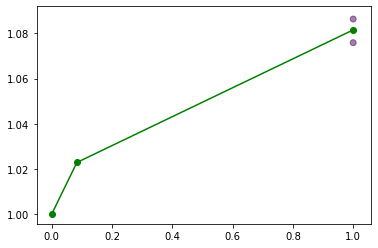

In [39]:
# take one test instance and plot prediction of VX,T = fX
index = np.random.randint(0, X_test.shape[0]) 
print(index)
x = X_test[index]
y = y_test[index]
# plot stock prices
S = S_test[index][0]
vt = V_T[index]

f_pred, sigma = m_1.gpr.predict(x, return_std=True)
time = [0,1/12,1]
plt.plot(time,S,"g-o")
plt.scatter([1,1,1],[f_pred + 1-3*sigma, f_pred+1, f_pred+1+3*sigma],c=[0.9,1,0.9],alpha=0.5) ## add K
plt.show()

-4


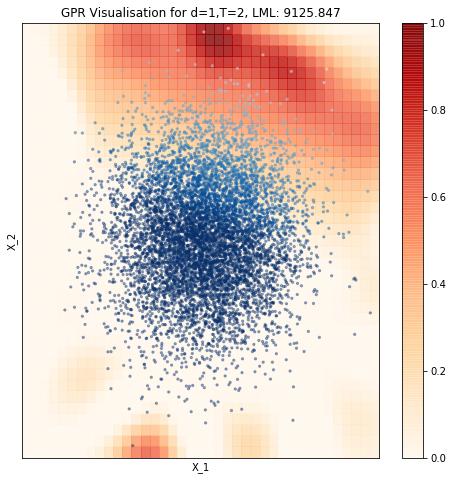

In [40]:
#Plot Kernel
h = 0.2

x_min, x_max = -4,4
y_min, y_max = -4,4
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
print(x_min)
title= "GPR Visualisation for d=1,T=2"
plt.figure(figsize=(8, 8))
# Plot the predicted probabilities. For that, we will assign a color to
# each point in the mesh [x_min, m_max]x[y_min, y_max].

Z = m_1.gpr.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.subplot(1,1,1)
a = plt.pcolor(xx,yy,Z, vmin=0, vmax=1,cmap='OrRd',alpha=0.8)
plt.colorbar(a)
# Plot also the training points
plt.scatter(X_test[:,0, 0], X_test[:,0, 1],c=1-y_test,cmap="Blues",alpha=0.4,s=5)
plt.xlabel('X_1')
plt.ylabel('X_2')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("%s, LML: %.3f" %
          (title, m_1.gpr.log_marginal_likelihood(m_1.gpr.kernel_.theta)))

plt.show()